# BD5write_circle

BD5write_circle is a sample code to demonstrate how to read in a TIFF image file and then segmented the image by image processing using Open CV libary routines. The resulting segmented ROI is then saved into a BD5 file. A simple routine to read back the data is also provided at the end.

This sample code requires the user to install several packages. They are:

- Pytables - http://www.pytables.org/index.html
- Numpy - https://numpy.org/
- OpenCV - https://opencv.org/


In [1]:
# Please consult the official websites for installation for your particular Operating system and environment.
# The following commands installed the necessary packages for juypter notebook in a Ubuntu docker container as a sample for your reference.

# Uncomment the # tag if you want the commands below to install those packages.

#!pip install tables

#!pip install numpy

#!pip install opencv-python



In [2]:
# Original Author: Koji Kyoda
# Date: 19 June 2020
# sample code for writing BD5 data (circle entity)
# Contributor: Ken ho 


import sys
import tables
from tables import *
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import warnings

# for supression of natural name warning
warnings.filterwarnings('ignore', category=tables.NaturalNameWarning)

# Main Objects for writing to BD5 file
# class definition
class ScaleUnit(IsDescription):
    dimension = StringCol(8, dflt="", pos=0)
    xScale = Float64Col(dflt=0, pos=1)
    yScale = Float64Col(dflt=0, pos=2)
    sUnit = StringCol(16, dflt="", pos=3)
    tScale = Float64Col(dflt=0, pos=4)
    tUnit = StringCol(16, dflt="", pos=5)

class ObjectDef(IsDescription):
    oID = UInt16Col(dflt=0, pos=0)
    name = StringCol(128, dflt="", pos=1)

class Data(IsDescription):
    ID = StringCol(32, dflt="", pos=0)
    t = Int32Col(dflt=0, pos=1)
    entity = StringCol(8, dflt="", pos=2)
    x = Float32Col(dflt=0, pos=3)
    y = Float32Col(dflt=0, pos=4)
    radius = Float32Col(dflt=0, pos=5)


## Defining the input TIFF image file and the output BD5 file

In [4]:
# input and output
img_path = "./bw_sample.tif"
hdf5_out = "./sample_circle_bd5.h5"

## Preprocess the image
* Read in the image as img
* Convert the image into a grayscale image
* Thresholding the image

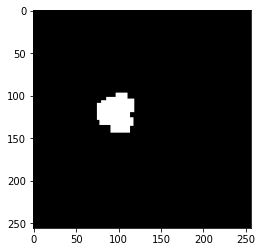

In [5]:
# preprocessing
img = cv2.imread(img_path)
imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(imgray, 'gray')

In [6]:
ret,thresh = cv2.threshold(imgray,127,255,0)
thresh

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

## Finding the contours of ROIs

In [7]:
# find contours of ROIs using the OpenCV findContours function
# Ref: https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html
# Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# To print out the contours, uncoment the line below.
#contours

In [8]:
# finding the size of the image
img.shape

(256, 256, 3)

## Diplaying the contours of the ROI

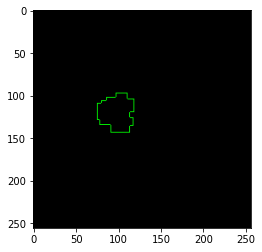

In [9]:
# creating a background image with the same dimension
bkimage = np.zeros((256, 256, 3), np.uint8)

# plot the contours over the background image
cv2.drawContours(bkimage, contours, -1, (0, 255, 0), 1) 
plt.imshow(bkimage)

## Overlaying the contour over the original image

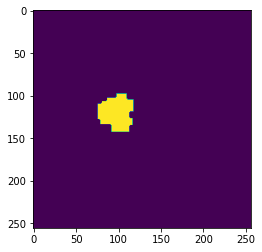

In [10]:
cv2.drawContours(imgray, contours, -1, (0, 255, 0), 1) 
plt.imshow(imgray)

In [2]:
# Uncomment the line below if you want to see the numerial values of the contours.
#contours

## Main routines to output the data into a BD5 format file

In [13]:
# output to bd5 file
h5file = open_file(hdf5_out, mode="w", title="bd5 file")

# Create a HDF5 datagroup called data using pytable function h5file.create_group
group = h5file.create_group('/', 'data', 'data group')

# for scaleUnit - create a HDF5 dataset scaleUnit under HDF5 datagroup /data using pytable funcion h5file.create_table
# Note: User needs to supply all the scale information, dimension, x, y, t, sUnit and tUnit 
scaleunit = h5file.create_table('/data', 'scaleUnit', ScaleUnit, "definition of scale and unit")
su = scaleunit.row
su['dimension'] = "2D"
su['xScale'] = 0.1
su['yScale'] = 0.1
su['sUnit'] = "micrometer"
su['tScale'] = 1
su['tUnit'] = "minute"
su.append()
scaleunit.flush()

# for objectDef - creat a HDF5 dataset objectDef under HDF5 datagroup /data using pytable h5file.create_table
# Note: User needs to supply object ID oIDs and names of the objects
objectdef = h5file.create_table('/data', 'objectDef', ObjectDef, "object definition")
od = objectdef.row
od['oID'] = 0
od['name'] = "nucleus"
od.append()
objectdef.flush()

# time series index - create a HDF5 datagroup under for each time frame or time point using pytable h5file.create_group
# The group name starts from 0 and increments continuously for each time frame or time point by 1
series = h5file.create_group('/data', '0', 'time index 0')

# object - create a HDF datagroup under time series index as object using pytable h5file.create_group
object0 = h5file.create_group('/data/0', 'object', 'object0')


# storing xy coordinates to HDF5 dataset named after oID defined in objectDef under datagroup object using pytable h5file.create_table
table = h5file.create_table('/data/0/object', '0', Data, "dataset")

xyz = table.row
for i, cnt in enumerates(contours):
    # the following lines calculate the centroid of the contour area
    # with that we also calculate the radius of a circle of the same area size.
    M = cv2.moments(cnt)
    area = cv2.contourArea(cnt)
    # note that radius store the actual size and does not multiply by any scale
    # In this case, the scale is 1 pixel = 0.1 micrometer, 
    # so radius below will be scaled by muliply with 0.1
    radius = math.sqrt(area/math.pi) * 0.1
    cx = M['m10'] / M['m00']
    cy = M['m01'] / M['m00']
    # xy coordinates and the circle radius are written to the HDF5 dataset
    xyz['ID'] = "o" + '%06d' % i
    xyz['t'] = 0
    xyz['entity'] = 'circle'
    xyz['x'] = cx
    xyz['y'] = cy
    xyz['radius'] = radius
    xyz.append()
table.flush()

# closing the BD5 file
h5file.close()



## Reading back the BD5 file

In [14]:
# how to read back the dataset
# In the code below we continue to use the Pytable package to access BD5 file

bd5file = tables.open_file(hdf5_out)
bd5file

File(filename=./sample_circle_bd5.h5, title='bd5 file', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) 'bd5 file'
/data (Group) 'data group'
/data/objectDef (Table(1,)) 'object definition'
  description := {
  "oID": UInt16Col(shape=(), dflt=0, pos=0),
  "name": StringCol(itemsize=128, shape=(), dflt=b'', pos=1)}
  byteorder := 'little'
  chunkshape := (504,)
/data/scaleUnit (Table(1,)) 'definition of scale and unit'
  description := {
  "dimension": StringCol(itemsize=8, shape=(), dflt=b'', pos=0),
  "xScale": Float64Col(shape=(), dflt=0.0, pos=1),
  "yScale": Float64Col(shape=(), dflt=0.0, pos=2),
  "sUnit": StringCol(itemsize=16, shape=(), dflt=b'', pos=3),
  "tScale": Float64Col(shape=(), dflt=0.0, pos=4),
  "tUnit": StringCol(itemsize=16, shape=(), dflt=b'', pos=5)}
  byteorder := 'little'
  chunkshape := (1024,)
/data/0 (Group) 'time index 0'
/data/0/object (Group) 'object0'
/dat

In [15]:
bd5file.root.data

/data (Group) 'data group'
  children := ['0' (Group), 'objectDef' (Table), 'scaleUnit' (Table)]

### Reading the objectDef 

In [16]:
objectdef = bd5file.root.data.objectDef.read()

In [17]:
objectdef

array([(0, b'nucleus')], dtype=[('oID', '<u2'), ('name', 'S128')])

In [18]:
objectdef['name'][0]

b'nucleus'

In [19]:
objectdef['oID'][0]

0

### Reading scaleUnit

In [20]:
scaleunit = bd5file.root.data.scaleUnit.read()

In [21]:
scaleunit[0]

(b'2D', 0.1, 0.1, b'micrometer', 1., b'minute')

In [22]:
scaleunit['dimension'][0]

b'2D'

### Reading object with oID 0 from time series index 0 

In [23]:
object0 = bd5file.get_node("/data/0/object", "0")

In [24]:
object0

/data/0/object/0 (Table(1,)) 'dataset'
  description := {
  "ID": StringCol(itemsize=32, shape=(), dflt=b'', pos=0),
  "t": Int32Col(shape=(), dflt=0, pos=1),
  "entity": StringCol(itemsize=8, shape=(), dflt=b'', pos=2),
  "x": Float32Col(shape=(), dflt=0.0, pos=3),
  "y": Float32Col(shape=(), dflt=0.0, pos=4),
  "radius": Float32Col(shape=(), dflt=0.0, pos=5)}
  byteorder := 'little'
  chunkshape := (1170,)

In [25]:
object0[0]

(b'o000000', 0, b'circle', 97.73062, 120.28173, 2.1934571)

In [26]:
object0[0]['ID']

b'o000000'

In [27]:
object0[0]['entity']

b'circle'

## Printing out the x, y centre of a circle in pixel value. Radius is in micrometers.

In [28]:
print("x: ", object0[0]['x'], "y: ", object0[0]['y'], "radius: ",  object0[0]['radius'])

x:  97.73062 y:  120.28173 radius:  2.1934571


## Displaying the circle in a background image - in pixel unit.

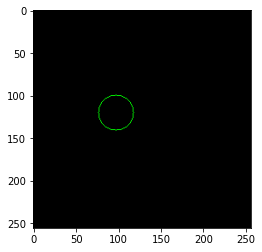

In [29]:
height, width = 256, 256
bkimg = np.zeros((height, width, 3), np.uint8)
colour = (0,255,0)
cv2.circle(bkimg, (object0[0]['x'], object0[0]['y']), int(object0[0]['radius']/0.1), colour, thickness=1, lineType=8, shift=0)
plt.imshow(bkimg)

## Displaying the circle overlaying on top of the original image

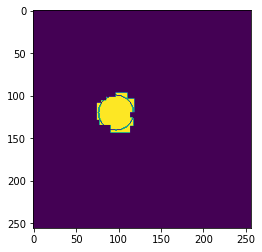

In [30]:
img = cv2.imread(img_path)
imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
cv2.circle(imgray, (object0[0]['x'], object0[0]['y']), int(object0[0]['radius']/0.1), colour, thickness=1, lineType=8, shift=0)
plt.imshow(imgray)

## Finding the circle of the ROI in actual micrometers

In [31]:
centre = (object0[0]['x'] * scaleunit[0]['xScale'], object0[0]['y'] * scaleunit[0]['yScale'])
centre

(9.773062133789063, 12.028173065185548)

In [32]:
radius = int(object0[0]['radius'])
radius

2

## Displaying the circle in micrometers

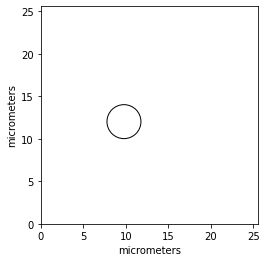

In [33]:
circle=plt.Circle(centre, radius, fill=False)
fig = plt.figure()
ax = fig.add_subplot(111,aspect='equal')  # subplot of 1x1 grid plot no. 1
# change default range so that new circles will display in micrometers
h, w, c = img.shape # size of the image in height, width, channel
xscale = h * scaleunit[0]['xScale']
yscale = w * scaleunit[0]['yScale']
ax.set_xlim((0, xscale))
ax.set_ylim((0, yscale))
plt.xlabel('micrometers')
plt.ylabel('micrometers')

#ax= plt.subplot(aspect='equal')
ax.add_artist(circle)
plt.show()


### Closing the BD5 file

In [34]:
bd5file.close()